In [2]:
pip install scikit-learn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.1 MB 6.6 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/11.1 MB 6.5 MB/s eta 0:00:02
   --------------- ------------------------ 4.2/11.1 MB 7.6 MB/s eta 0:00:01
   -------------------- ------------------- 5.8/11.1 MB 7.7 MB/s eta 0:00:01
   --------------------------- ------------ 7.6/11.1 MB 7.8 MB/s eta 0:00:01
   ---------------------------------- ----- 9.7/11.1 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 8.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Load your GeoPackage with tree locations
gdf = gpd.read_file('output.gpkg')

# Function to load prediction and extract values at px, py
def extract_predictions_for_image(image_id):
    npy_path = f'Inference output/heights_{image_id}.npy'
    try:
        prediction_array = np.load(npy_path)
    except FileNotFoundError:
        print(f"Prediction file not found for {image_id}")
        return None

    # Select only rows matching this image
    image_rows = gdf[gdf['image'] == f'{image_id}.png'].copy()
    predictions = []

    for idx, row in image_rows.iterrows():
        x, y = int(round(row['px'])), int(round(row['py']))
        # Validate coordinates are within bounds
        if 0 <= y < prediction_array.shape[0] and 0 <= x < prediction_array.shape[1]:
            predicted_value = prediction_array[y, x]
        else:
            predicted_value = np.nan  # Out of bounds, mark as NaN
        predictions.append(predicted_value)

    image_rows['Predicted'] = predictions
    return image_rows.dropna(subset=['Predicted'])

# Process all unique images
results = []
for image_id in gdf['image'].str.replace('.png', '').unique():
    result = extract_predictions_for_image(image_id)
    if result is not None:
        results.append(result)

# Combine all into a single DataFrame
if results:
    all_results = pd.concat(results, ignore_index=True)
    print(all_results.head())
else:
    print("No data matched.")


        ID                Date  Height   Species     image          px  \
0  3296001 2023-08-24 18:23:02    4.30  Ilmbjörk  3296.png  120.985212   
1  3296003 2023-08-24 18:23:02    5.30  Ilmbjörk  3296.png  123.437114   
2  3296005 2023-08-24 18:23:02    3.80  Ilmbjörk  3296.png  124.501909   
3  3296006 2023-08-24 18:23:02    5.21  Ilmbjörk  3296.png  124.443830   
4  3296007 2023-08-24 18:23:02    7.44  Ilmbjörk  3296.png  133.617409   

           py                                geometry  Predicted  
0  121.801100  POINT Z (-19.49256 63.52876 103.93267)   0.117854  
1  124.475135  POINT Z (-19.49254 63.52874 102.90667)   0.038197  
2  125.320163  POINT Z (-19.49253 63.52874 102.58067)   0.021764  
3  126.280853  POINT Z (-19.49253 63.52874 102.30167)   0.025722  
4  126.983857  POINT Z (-19.49243 63.52873 102.78767)   0.314760  


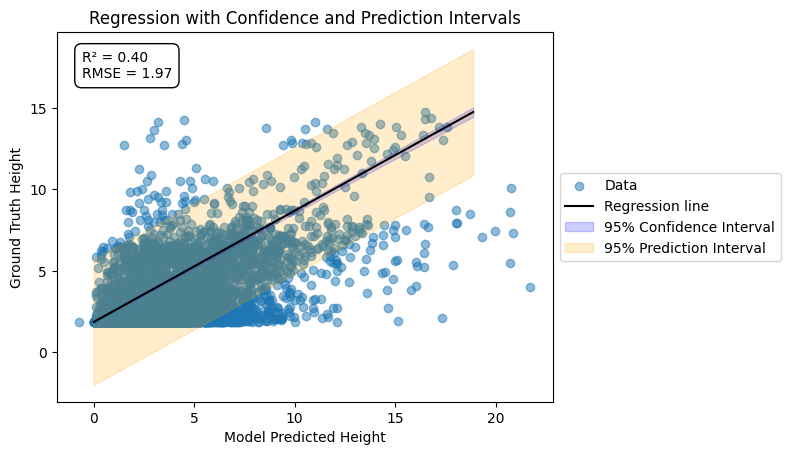

In [23]:
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def compute_intervals(X, y, model, confidence=0.95):
    # Sort X for plotting
    X_sorted = np.sort(X.flatten())
    y_pred = model.predict(X_sorted.reshape(-1, 1))
    
    n = len(X)
    mean_x = np.mean(X)
    t_value = stats.t.ppf((1 + confidence) / 2., n - 2)
    s_err = np.sqrt(np.sum((y - model.predict(X)) ** 2) / (n - 2))
    
    confs = t_value * s_err * np.sqrt(1/n + (X_sorted - mean_x)**2 / np.sum((X - mean_x)**2))
    preds = t_value * s_err * np.sqrt(1 + 1/n + (X_sorted - mean_x)**2 / np.sum((X - mean_x)**2))
    
    return X_sorted, y_pred, confs, preds

# Compute intervals
X_sorted, y_pred_sorted, confs, preds = compute_intervals(X, y, model)

# Calculate metrics
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Plot data points
plt.scatter(y, y_pred, alpha=0.5, label='Data')

# Plot regression line
plt.plot(X_sorted, y_pred_sorted, color='black', label='Regression line')

# Plot confidence interval
plt.fill_between(X_sorted, y_pred_sorted - confs, y_pred_sorted + confs, color='blue', alpha=0.2, label='95% Confidence Interval')

# Plot prediction interval
plt.fill_between(X_sorted, y_pred_sorted - preds, y_pred_sorted + preds, color='orange', alpha=0.2, label='95% Prediction Interval')

# Annotate R2 and RMSE
plt.text(0.05, 0.95, f'R² = {r2:.2f}\nRMSE = {rmse:.2f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Place legend at bottom right, out of the way
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Model Predicted Height')
plt.ylabel('Ground Truth Height')
plt.title('Regression with Confidence and Prediction Intervals')
plt.show()


Skipping Silfurreynir (only 1 sample)
Skipping Álmur (only 1 sample)
Skipping Douglasgreni (only 1 sample)
Skipping Kjarrölur (only 1 sample)
Skipping Fura (only 1 sample)
Skipping Heggur (only 1 sample)
Skipping Fjallafura (only 1 sample)


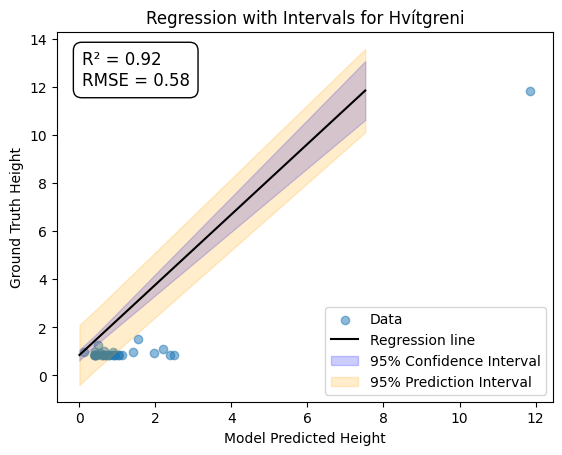

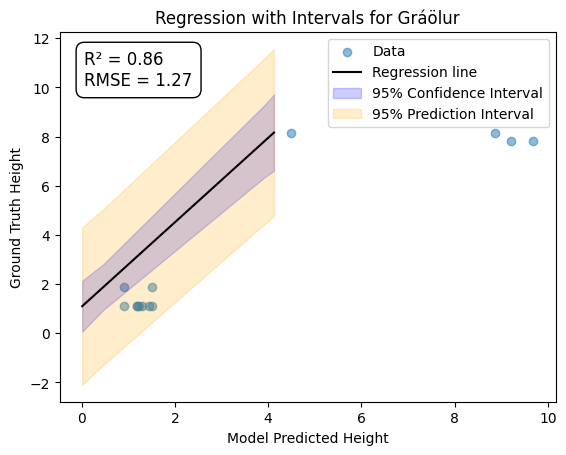

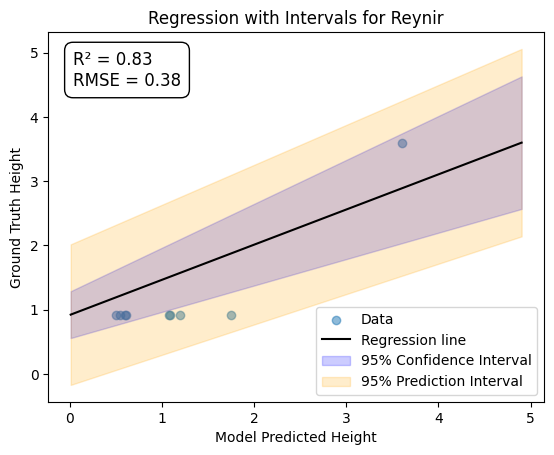

In [17]:
import matplotlib.pyplot as plt
from scipy import stats

# Collect evaluation metrics for all species first
species_metrics = []

for species in clean_results['Species'].unique():
    species_results = clean_results[clean_results['Species'] == species]
    
    # Skip species with fewer than 2 samples
    if len(species_results) < 2:
        print(f"Skipping {species} (only {len(species_results)} sample)")
        continue

    X_species = species_results[['Predicted']].values
    y_species = species_results['Height'].values

    model_species = LinearRegression()
    model_species.fit(X_species, y_species)
    y_pred_species = model_species.predict(X_species)

    r2_species = r2_score(y_species, y_pred_species)
    rmse_species = np.sqrt(mean_squared_error(y_species, y_pred_species))

    species_metrics.append({
        'Species': species,
        'R2': r2_species,
        'RMSE': rmse_species,
        'X': X_species,
        'y': y_species,
        'model': model_species
    })

# Sort by best R² descending and select top 3
top_species = sorted(species_metrics, key=lambda x: x['R2'], reverse=True)[:3]

for species_data in top_species:
    species = species_data['Species']
    X_species = species_data['X']
    y_species = species_data['y']
    model_species = species_data['model']
    r2_species = species_data['R2']
    rmse_species = species_data['RMSE']

    # Compute intervals
    X_sorted, y_pred_sorted, confs, preds = compute_intervals(X_species, y_species, model_species)

    # Plot
    plt.figure()
    plt.scatter(y_species, model_species.predict(X_species), alpha=0.5, label='Data')
    plt.plot(X_sorted, y_pred_sorted, color='black', label='Regression line')
    plt.fill_between(X_sorted, y_pred_sorted - confs, y_pred_sorted + confs, color='blue', alpha=0.2, label='95% Confidence Interval')
    plt.fill_between(X_sorted, y_pred_sorted - preds, y_pred_sorted + preds, color='orange', alpha=0.2, label='95% Prediction Interval')

    # Annotate R2 and RMSE
    plt.text(0.05, 0.95, f'R² = {r2_species:.2f}\nRMSE = {rmse_species:.2f}',
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.xlabel('Model Predicted Height')
    plt.ylabel('Ground Truth Height')
    plt.title(f'Regression with Intervals for {species}')
    plt.legend()
    plt.show()


In [ ]:
import pandas as pd

# Convert species_metrics to a DataFrame
metrics_table = pd.DataFrame([
    {'Species': entry['Species'], 'R2': entry['R2'], 'RMSE': entry['RMSE']}
    for entry in species_metrics
])

# Sort by R2 descending for easy comparison
metrics_table_sorted = metrics_table.sort_values(by='R2', ascending=False).reset_index(drop=True)

dfi.export(metrics_table_sorted, 'species_regression_metrics.png')
# Display the table
metrics_table_sorted


,Species,R2,RMSE
0,Hvítgreni,0.915073,0.580850
1,Gráölur,0.857870,1.266339
2,Reynir,0.826999,0.384873
3,Broddgreni,0.704893,1.573422
4,Lindifura,0.599587,0.567409
5,Hengibirki,0.525445,1.658393
6,Rússa- og síberíulerki,0.510228,1.899771
7,Sitkagreni,0.506718,1.698819
8,Selja,0.498671,1.217957
9,Stafafura,0.491470,1.783181


In [ ]:
# Run the regression

# Filter out rows where Height or Predicted is NaN
# Predicted height doesn't have ground truth.
clean_results = all_results.dropna(subset=['Height', 'Predicted'])

# check how much was filtered out
print(f"Original samples: {len(all_results)}")
print(f"Samples after filtering NaNs: {len(clean_results)}")
print(f"Number of filtered out samples: {len(all_results) - len(clean_results)}")

# Prepare data for regression
X = clean_results[['Predicted']].values
y = clean_results['Height'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print("R2 Score:", r2)
print("RMSE:", rmse)

Original samples: 11956
Samples after filtering NaNs: 10385
Number of filtered out samples: 1571
R2 Score: 0.3992440914227914
RMSE: 1.9699228641493276


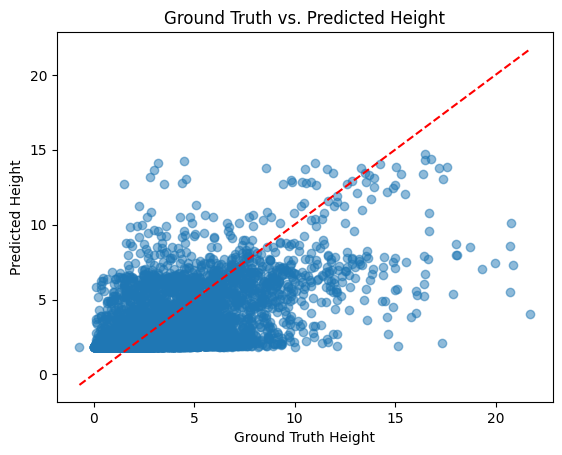

In [9]:
# Plot True vs Predicted for Visual Check

import matplotlib.pyplot as plt

plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel('Ground Truth Height')
plt.ylabel('Predicted Height')
plt.title('Ground Truth vs. Predicted Height')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Line y=x for reference
plt.show()



In [12]:
# How many had missing Height to begin with?
missing_heights = all_results[all_results['Height'].isna()]
print(f"Samples with missing Height (Ground Truth): {len(missing_heights)}")

# Show some examples if any
print(missing_heights.head())


Samples with missing Height (Ground Truth): 1571
           ID                Date  Height   Species      image          px  \
203  15188006 2020-08-20 15:38:32     NaN  Ilmbjörk  15188.png  129.516773   
204  15188007 2020-08-20 15:38:32     NaN  Ilmbjörk  15188.png  127.984753   
205  15188008 2020-08-20 15:38:32     NaN  Ilmbjörk  15188.png  126.736528   
206  15188009 2020-08-20 15:38:32     NaN  Ilmbjörk  15188.png  121.218262   
220  15292002 2021-08-12 15:20:39     NaN  Ilmbjörk  15292.png  129.277011   

             py                               geometry  Predicted  
203  122.683126   POINT Z (-20.22792 63.8024 46.11211)   0.010052  
204  120.449501  POINT Z (-20.22793 63.80241 46.11211)   0.010053  
205  118.121332  POINT Z (-20.22795 63.80242 46.11211)   0.010054  
206  119.266634  POINT Z (-20.22801 63.80241 46.11211)   0.010053  
220  121.651419  POINT Z (-18.03634 63.80442 20.55349)   0.016179  
